# Text Clustering

Text clustering is a major task in NLP and in other areas, and is one of the most common task for unspervised learning

In this notebook, I am going to apply **unsupervised learning** techniques to group similar news articles from the BBC News dataset. Using different **text vectorization methods**, I am going to explore how well various clustering algorithms can categorize the news articles into meaningful groups.


## List of Contents

1. **Load and prepare data**  
   - Load text data. Preprocess and create vectorized representations (TF-IDF, Word2Vec, SBERT).

2. **Apply Clustering Algorithms**  
   - Use **K-Means**, **Hierarchical Clustering**, and **DBSCAN** to identify clusters.

3. **Evaluate Clustering Performance**  
   - Compute **Silhouette Score**, **Davies-Bouldin Index**, and **Adjusted Rand Index (ARI)** (if labels are available).

4. **Visualize Clusters**  
   - Reduce dimensionality using **PCA or t-SNE**.
   - Plot cluster distributions to analyze how well-separated they are.

5. **Compare Embedding Methods**  
   - Evaluate clustering results for **TF-IDF, Word2Vec, and SBERT**.
   - Discuss which embedding method is most effective for clustering news articles.

## 🛠 Tech Stack
- **Python** (pandas, numpy, matplotlib, seaborn)
- **scikit-learn** (K-Means, evaluation metrics)
- **gensim** (Word2Vec)
- **sentence-transformers** (SBERT embeddings)
- **hdbscan** (Density-based clustering)

## 🎯 Expected Outcome
- A clear comparison of **how different embeddings affect clustering**.
- Identification of **the best approach for grouping news articles** without predefined labels.
- Insights into **how well clusters align with actual news categories**.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
from gensim.models import Word2Vec
from sentence_transformers import SentenceTransformer

c:\Users\ezequ\Documents\Python\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. **Load and prepare data**

I am going to work again with the BBC News dataset

In [2]:
# Import data 

df = pd.read_csv("bbc-text.csv")

Preprocess the text data: at this step each piece of news is going to be tokenized so later the embeddings can be obtained

In [3]:
nlp = spacy.load("en_core_web_sm")  # load the english NLP model

def preprocess_texts(texts):
    processed_texts = []
    for doc in nlp.pipe(texts, disable=["ner", "parser"]):  
        tokens = [token.lemma_ for token in doc if not token.is_punct and not token.is_stop]
        processed_texts.append(" ".join(tokens))
    return processed_texts

df["processed_text"] = preprocess_texts(df["text"])

In [4]:
# TF-IDF 

tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # stick with the 5000 most common words
tfidf_matrix = tfidf_vectorizer.fit_transform(df["processed_text"]).toarray()

In [5]:
# Word2Vec 

texts = df["processed_text"].tolist()
w2v_model = Word2Vec(sentences=[text.split() for text in texts], vector_size=300, window=5,  min_count=2, workers=4)
word_vectors = np.array([np.mean([w2v_model.wv[word] for word in text.split() if word in w2v_model.wv], axis=0) for text in texts])

In [6]:
# BERT

sbert_model = SentenceTransformer('all-MiniLM-L6-v2') 
df['sbert_embedding'] = df['processed_text'].apply(lambda x: sbert_model.encode(x))
sbert_embeddings = np.stack(df['sbert_embedding'].values)


### 2. **Apply Clustering Algorithms**

#### K-Means clustering

K-means is an unsupervised clustering algorithm that partitions data into k clusters by iteratively updating cluster centroids to minimize intra-cluster variance (sum of squared distances). It is simple, easy to implement, and efficient even on large datasets, making it widely used. On the flip side, K-means performs best when clusters are roughly spherical and of similar size, which is not always the case. Additionally, the number of clusters (k) must be specified beforehand, which can be a challenging problem all by itself.

#### How to select the number of clusters to initialize K-Means algorithm?

Before applying the K-Means algorithm, I will use both the **elbow method** and the **silhouette score** to determine the optimal number of clusters. Since they have different strengths, using them together provides a more well-rounded analysis, especially in cases where the optimal k is not clear.

#### Elbow method

It measures how compact clusters are by evaluating within-cluster variance (or inertia). This technique helps determine the optimal number of clusters by identifying the point where adding more clusters no longer significantly reduces inertia (this is a key point to make since adding more clusters always reduces the distance between points and their assigned centroids). In this regard detecting the elbow isn't always clear. 

This method is particularly useful for datasets with well-defined clusters, as it focuses solely on how tightly data points are grouped rather than how well-separated the clusters are.

In [ ]:
import elbow

#### Silhouette score

It takes into account both cohesion (similarity inside the cluster) and separation (differences between clusters). A higher score means better-defined clusters. For a suscint and clear explanation see [here](https://www.youtube.com/watch?v=a2Kg2_l3L8M) 

In [ ]:
import silhouette

Let's apply the elbow method to the vectors generated with the TF-IDF method:

In [ ]:
elbow.elbow_method(tfidf_matrix, max_k=10)

**How to interpret this plot?**

This plot shows the inertia as a function of the number of clusters. The fact that the inertia is a monotonic decreasing function is expected.

Here we have to look for the "elbow" point: this is where the rate of decrease in inertia slows down significantly. In this plot however, there is no clear elbow. The decrease appears quite linear (with the same slope value that is) across all the domain of k. But the largest drop happens between $k = 1$ and $k = 3$ and after that the reduction appears more gradual. If forced to choose based on this plot alone, $k=3$ might be reasonable.

Since the elbow method appears to be non-conclusive, let's check now the **silhouette score**

In [ ]:
silhouette.silhouette_method(tfidf_matrix, max_k=15)

**How to interpret this plot?**

As mentioned before, the silhouette score measures clustering quality ( higher values indicate better defined and well separated clusters)

The silhouette score at $k = 3$ is low compared to higher k values. This suggest that increasing k improves clustering quality.

At $k = 8$ the silhouette score reaches a local maximum, which might indicate distinct and well-separated clusters.

The drop after this value may suggests this well defined clusters are being split into smaller, less meaningful ones (this is known as *over-segmentation*)

The increase around $k = 14$ could mean that there is an *underlying substructure*, and subsequent partition of the data helps to capture this. However, too high k risks overfitting by artificially creating more clusters than needed.


**Why is the silhouette score more reliable in this case?**

The elbow method only considers inertia, which measures how compact clusters are. However, compact clusters do not always mean good separation. The silhouette score takes into acount both intra and inter cluster distance.

Now let's apply this methods to the vectors generated with Word2Vec:

In [ ]:
# Apply elbow method

elbow.elbow_method(word_vectors)

Here, $k = 4$ or $k = 5$ are good candidates: inertia decreases much more slowly for $k > 5$

In [ ]:
# Calculate silhouette score 

silhouette.silhouette_method(word_vectors)

Silhouette score is the greatest for $k = 4$. In this case, the k's obtained with both methods coincide!

Finally, apply this methods to the vectors generated with SBERT:

In [ ]:
# Apply elbow method

elbow.elbow_method(sbert_embeddings)

Here, $k = 4$, $k = 5$ or even $k = 7$ are possible candidates. 

In [ ]:
# Calculate silhouette score 

silhouette.silhouette_method(sbert_embeddings)

Applying a similar criteria as the one in the first case, I will select $k = 4$ as the best candidate.

Then the number of clusters for initializing K-Means for the three arrays of vectors are:

$$
\begin{array}{|c|c|c|c|}
\hline
\text{\# clusters} & \text{TF-IDF} & \text{Word2Vec} & \text{SBERT} \\
\hline
k & 8 & 4 & 4 \\
\hline
\end{array}
$$


Now it's time to apply the K-Means algorithm.

In [ ]:
import kmeans

In [ ]:
# Apply K-Means clustering to the generated vectors

tfidf_labels, tfidf_inertia = kmeans.kmeans_clustering(tfidf_matrix, k=8)
word_labels, word_inertia = kmeans.kmeans_clustering(word_vectors, k=4)
sbert_labels, sbert_inertia = kmeans.kmeans_clustering(sbert_embeddings, k=4)

### Hierarchical Clustering

Hierarchical clustering builds a *hierarchy of clusters* that can be cut at different levels to obtain different groupings. It works in two main ways, top-down and bottom-up (agglomerative) approaches, with the bottom-up method being the most common.

The result of this process is a tree-like graph called a **dendrogram**.  This kind of plots give a clear visualization of data relationships, for instance, the height at which two clusters merge represents their distance. By cutting the dendrogram at a specific height, you can determine the final clusters.

One strength of hierarchical clustering, compared to methods like k-means, is that it doesn’t require predefining the number of clusters. On the flip side it becomes computationally expensive for large datasets and is sensitive to noise and outliers.


### DBSCAN

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is a clustering algorithm that identifies groups of densely packed points while distinguishing noise (outliers). It classifies each data point as a core, border, or noise point based on two key parameters: $\epsilon$ which is the maximum distance within which points are considered neighbors and the minimum number of neighboring points (MinPts). Using this concepts we can define **core** points as those who have at least MinPts number of points within the distance $\epsilon$. This form the dense regions of the cluster and is the first thing the model computes for buiding each cluster.

A **border** point lies within $\epsilon$ of a core point but has fewer than MinPts neighbors itself. These points help expand clusters but do not initiate them. **Noise** points are those that cannot be reached from any core point, meaning they do not belong to any cluster. These are treated as outliers.

DBSCAN starts by identifying core points, then it expands clusters by connecting reachable border points, and leaves isolated points as noise. Because of this, the algorithm can deal with arbitrarily shaped clusters and handdle noise in the data.

Unlike other methods, the number of clusters does not need to be specified beforehand. However, despite being able to find clusters of arbitrary shape, it can struggle with clusters of varying *densities*. The model is very sensitive to parameter choice, so determining adequate values for $\epsilon$ and MinPts is crucial.

#### Hyperparameter tunning

As mentioned before, $\epsilon$  defines the **maximum radius** around a point that is considered part of its neighborhood. It determines *how close* points must be to one another to be considered part of the same cluster.

If $\epsilon$ is too small, you might end up with too many small clusters, or the algorithm may classify most points as noise. If it's too large, the it might group distinct clusters together.

A K-distance plot is the usual way for tuning the $\epsilon$ parameter. It helps determine the optimal value by analyzing the distances between each point and its k-th nearest neighbor.

In [7]:
from k_nearest import distance_plot

The function takes as arguments MinPts (the second parameter of DBSCAN) and the metric used to calculate distances. It may seem counterintuitive that the distance  needs to be tuned while MinPts hasn't been optimized beforehand.

The value of MinPts depends on both the dimensionality and size of the dataset. A common rule of thumb is to set MinPts to at least twice the number of dimensions. For example, for a 2D dataset, MinPts might be set to 4. For very high dimensions, a higher MinPts is generally recommended.

Another important consideration is that calculating distances in high-dimensional spaces is challenging due to the curse of dimensionality. In high-dimensional data, Euclidean distance becomes less meaningful, as the difference between the nearest and farthest points diminishes. Because of this, alternative distance metrics should be considered. In this case, I chose cosine similarity, as DBSCAN is well-suited for it.

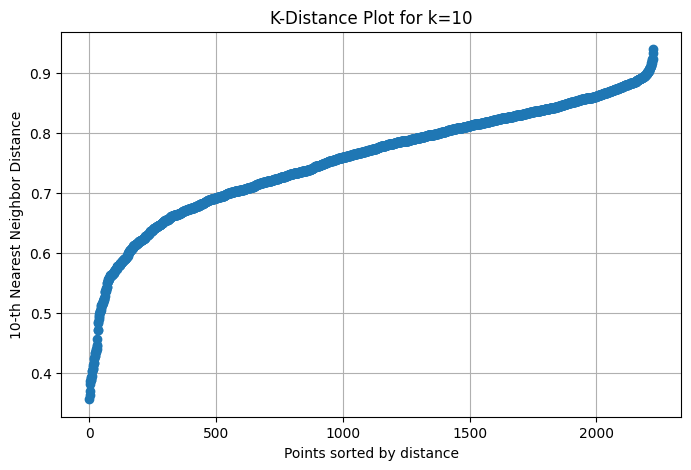

In [8]:
# For example:

distance_plot(tfidf_matrix, 10)

**How to read this plot?**

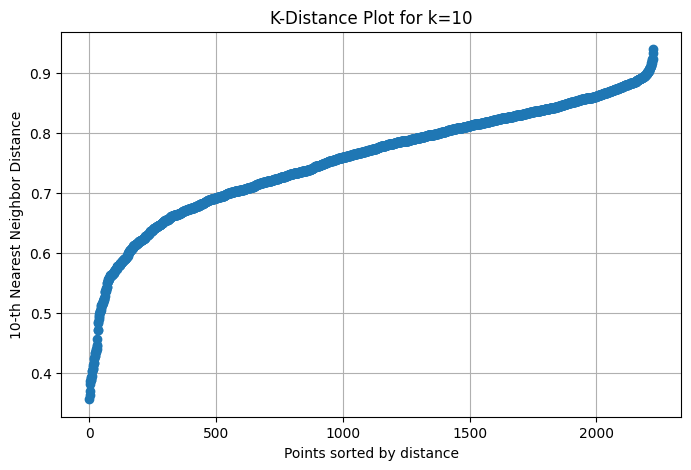

In [9]:
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_distances

distance_matrix = cosine_distances(tfidf_matrix)

k=10

neigh = NearestNeighbors(n_neighbors=k, metric='precomputed')
neigh.fit(distance_matrix)
distances, _ = neigh.kneighbors(distance_matrix)

k_distances = np.sort(distances[:, k-1])  # Sort distances

plt.figure(figsize=(8, 5))
plt.plot(k_distances, marker='o')
plt.xlabel("Points sorted by distance")
plt.ylabel(f"{k}-th Nearest Neighbor Distance")
plt.title(f"K-Distance Plot for k={k}")
plt.grid(True)
plt.show()

## Progress Notes (Date: 2025-02-25)
- The shape of the K-distance plot is different to what is to be expected.
- Next steps:
  1. Investigate why this is the case


MinPts: This is the minimum number of points that must exist within the ε-radius to form a dense region (core point). It's typically set to a value based on the dimensionality of the data. For instance, a common choice is MinPts = 4 for 2D data, but this can vary depending on the context and dataset.

The silhouette score treats DBSCAN's noise assignements as cluster of its own (as they are all -1). That's wrong, and it will work against DBSCAN. IMHO better to drop them before computing the silhouette.

Nice article, however I don't think the silhouette coefficient is well adapted for density-based clustering (it doesn't work well when clusters are not convex).